In [12]:
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import util

import nltk
import numpy as np
import math
import io

import pandas as pd
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# https://github.com/nguyenkh/AntSynDistinction
WORDVEC_PATH = r'C:\Users\Barry Li\Documents\nlp\project\vec\glove.6B.100d.w2v.txt'

model = KeyedVectors.load_word2vec_format(WORDVEC_PATH, binary=False)

In [6]:
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
model.similarity('sincere', 'skeptical')

0.4005436797683082

In [7]:
test = 'Wow. This is definitely not the usual North Korea bluffing. Consider me cautiously optimistic.'

def neg_tokenize(text):
    tokens = util.mark_negation(nltk.word_tokenize(text))
    return tokens

In [8]:
positive_keywords = ['sincere', 'respectful', 'real']
model.most_similar(positive=positive_keywords, negative=['bad'])

[('constructive', 0.6776089668273926),
 ('polite', 0.6698967218399048),
 ('passionate', 0.6607860326766968),
 ('pragmatic', 0.6521741151809692),
 ('forthright', 0.6513423919677734),
 ('thoughtful', 0.648894190788269),
 ('heartfelt', 0.6428238153457642),
 ('honest', 0.6281126141548157),
 ('candid', 0.6230484247207642),
 ('genuine', 0.6205928325653076)]

In [27]:
negative_keywords = ['scared', 'anxious', 'cautious', 'stressful', 'alert', 'emotion', 'attitude']
negative_keywords = ['untrustworthy', 'unbelievable', 'skeptical']
model.most_similar(positive=negative_keywords, negative=['good'])

[('mystified', 0.7095894813537598),
 ('flummoxed', 0.6836551427841187),
 ('incredulous', 0.6791216135025024),
 ('perplexed', 0.6623954176902771),
 ('astonished', 0.6577024459838867),
 ('aghast', 0.6559686660766602),
 ('hypocritical', 0.6529419422149658),
 ('unmoved', 0.6505042314529419),
 ('baffled', 0.6449019908905029),
 ('astounded', 0.643958568572998)]

In [10]:
def read_stopwords(filename):
    stopwords = []
    with io.open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            stopwords.append(line)
    return frozenset(stopwords)
        

def generate_features(pos, neg, stopwords, topn=2000):
    pos_200 = model.most_similar(positive=positive_keywords, negative=['bad'], topn=topn)
    neg_200 = model.most_similar(positive=negative_keywords, negative=['good'], topn=topn)

    uni_features = {}
    for p in pos:
        uni_features[p.lower()] = 1
    for n in neg:
        uni_features[n.lower()] = -1
    for word, sim in pos_200:
        word = word.lower()
        score = uni_features.get(word, 0)
        uni_features[word] = score + sim
    for word, sim in neg_200:
        word = word.lower()
        score = uni_features.get(word, 0)
        if score > sim:
            uni_features[word] = score
        else:
            uni_features[word] = sim * -1

    for stopword in stopwords:
        uni_features.pop(stopword, None)
    return uni_features

stopwords = read_stopwords('stopwords.txt')
uni_features = generate_features(positive_keywords, negative_keywords, stopwords)
print('pos', len([v for k, v in uni_features.items() if v > 0]))
print('neg', len([v for k, v in uni_features.items() if v < 0]))

pos 1635
neg 1957


In [13]:
class SentAnalyzer():
    
    def __init__(self, features):
        neg_features = self.duplicate_negation(features)
        neg_features.update(features)
        self.features = neg_features
        idxs = {feat: i for i, feat in enumerate(self.features)}
        self.idxs = idxs
        self.vectorizer = CountVectorizer(vocabulary=idxs, tokenizer=neg_tokenize)
        flipped_idxs = {i: self.features[feat] for feat, i in idxs.items()}
        self.weights = np.array([flipped_idxs[i] for i in range(len(flipped_idxs))])
    
    def duplicate_negation(self, features):
        neg_features = {
            '{}_NEG'.format(feat): -1 * score for feat, score in features.items()
        }
        return neg_features
    
    def normalize(self, score, alpha=5):
        """Normalizing function as described by VADER Sentiment analyzer"""
        return score / np.sqrt((score * score) + alpha)
    
    def polarize(self, passages):
        """Calculate the polarity of a passage.
        
        passage [str]: a list of strings representing tokens
        """
        bow_vec = self.vectorizer.transform(passages)
        return bow_vec.dot(self.weights)
    
    def predict(self, passage):
        return self.normalize(self.polarize(passage))
    
SA = SentAnalyzer(uni_features)
test2 = "I'm still really skeptical myself. This is all just too good to be true. \nWhat the fuck is Kim actually planning? How the fuck is North Korea going to unify with South Korea when NK has the most fucked up and brainwashed population in existence?"
test3 = "I'm really optimistic. I hope this succeeds."
test4 = "Is it really happening? There is no obvious reason to believe him and this is all happening so fast? Could something amazing actually be happening here?"
test5 = "Got the warning on my phone. I was just talking to friends on discord then heard the weird note from my phone that I hear for the first time. I checked it says missile. I was terrified checking every news source and calling friends. Then got another saying it passed over. That was terrifying."
test6 = "I've been living in northern Japan for some time and have never seen this kind of response to a missile launch before. The alerts, the news broadcasts, it was not taken lightly. Regardless of where the missile ended up, I think the message it sent is one that will have some lasting implications on how we perceive North Korea's aggression. It's only a matter of time before they end their war with Poseidon and make the mistake of targeting actual human lives. Stay safe out there, everyone."
test7 = "Their targeting systems and missiles are far from foolproof. A missile failure could have dropped this missile on an inhabited area in Japan. That would likely have provoked a full scale war. The level of irresponsibility here is just staggering."
test8 = "Man, that must be scary as shit. The other day I just arrived in Brussels and sat down in the Grand Place (a big open square, right in the center of Brussels) and then got a BBC alert 'Machete-wielding man attacks soldiers in central Brussels'. My heart skipped a beat. It was just a couple of streets away. I felt kinda sick. I did hear police sirens earlier but didn't think much of it. There were also soldiers and police all over the place."
print(SA.predict([test, test2, test3, test4, test5, test6, test7, test8]))

[ 0.47395905  0.23442231  0.46131361 -0.03056636  0.10029979  0.17551532
  0.          0.        ]


In [14]:
# Load pandas datafram of reddit data from pickle
df = pickle.load( open( "firsttry.p", "rb" ))


In [15]:
# Predict sentiment on each reddit comment# Predict 
df["sentiments"] = SA.predict(df["body"])

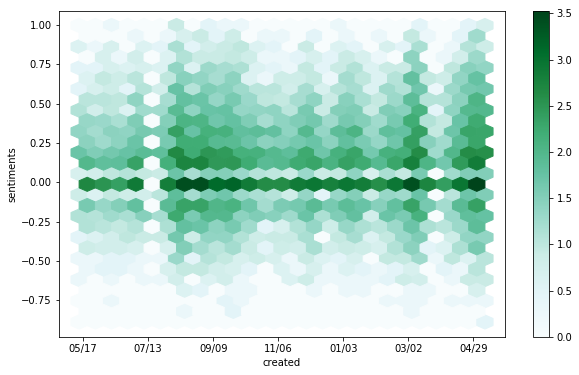

In [26]:
from datetime import datetime
pl_df = df.copy()
pl_df["created"] = df.created.astype(np.int64)

fig, ax = plt.subplots(figsize=(10,6))
pl_df.plot.hexbin(x='created', y='sentiments', ax=ax, gridsize=25, reduce_C_function=np.max, bins='log')
ax.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%m/%d') for ts in ax.get_xticks()])
fig.savefig('chart.png')
plt.show()


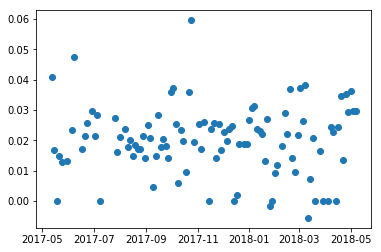

In [229]:
# Bucket on 7 days and plot a graph of average sentiment over these times
df["created"] = pd.to_datetime(df["created"], utc=True)
df = df.set_index("created")
df.index = df.index.floor('3D')
df = df.reset_index()
df_weekly_sentiments = df.groupby('created')['sentiments'].mean().reset_index()
plt.plot_date(df_weekly_sentiments["created"], df_weekly_sentiments["sentiments"])